## Analyze feature importance

In [1]:
%matplotlib inline

In [2]:
import json

from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_momentum_studies import TALibMomentumStudies
from Code.lib.model_utils import ModelUtility, TimeSeriesSplitImproved
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os.path
import pickle

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Load issue data and set date range
Pivot date is last date and time segments calculated by OOS months and IS-OOS ratio

In [5]:
plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
candle_ind = CandleIndicators()
dSet = DataRetrieve()
taLibMomSt = TALibMomentumStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
    
issue = "TLT"
# Set IS-OOS parameters
pivotDate = datetime.date(2018, 4, 2)
is_oos_ratio = 3
oos_months = 4
segments = 2

dataSet = dSet.read_issue_data(issue)

# get first data from loaded data instead of hard coding start date
dataSet = dSet.set_date_range(dataSet, "2014-09-26", pivotDate)

#set beLong level
beLongThreshold = 0.000
dataSet = ct.setTarget(dataSet, "Long", beLongThreshold)

Successfully retrieved data series for TLT


### Set features
Features should be normalized...

In [6]:
input_dict = {} # initialize
input_dict = {'f1': 
          {'fname' : 'ATR', 
           'params' : [5],
           'transform' : ['Normalized', 50]
           },
          'f2': 
          {'fname' : 'RSI', 
           'params' : [2],
           'transform' : ['Normalized', 50]
           },
          'f3': 
          {'fname' : 'DeltaATRRatio', 
           'params' : [2, 10],
           'transform' : ['Scaler', 'robust']
           },
          'f4': 
          {'fname' : 'ATRRatio', 
           'params' : [10, 30],
           'transform' : ['Normalized', 50]
           },
          'f5': 
          {'fname' : 'Lag', 
           'params' : ['Close', 3],
           'transform' : ['Normalized', 50]
           },
          'f6': 
          {'fname' : 'PPO', 
           'params' : [12, 26],
           'transform' : ['Normalized', 50]
           },
          'f7': 
          {'fname' : 'CMO', 
           'params' : [10],
           'transform' : ['Normalized', 50]
           },
          'f8': 
          {'fname' : 'CCI', 
           'params' : [10],
           'transform' : ['Normalized', 50]
           },
          'f9': 
          {'fname' : 'ROC', 
           'params' : [10],
           'transform' : ['Normalized', 50]
           }
         }        
dataSet = featureGen.generate_features(dataSet, input_dict)

f1
Current feature:  ATR_5
transform:  ['Normalized', 50]
f2
Current feature:  RSI_2
transform:  ['Normalized', 50]
f3
Current feature:  DeltaATRratio_S2_L10
transform:  ['Scaler', 'robust']
f4
Current feature:  ATRratio_S10_L30
transform:  ['Normalized', 50]
f5
Current feature:  ATRratio_S10_L30_Normalized
transform:  ['Normalized', 50]
f6
Current feature:  PPO_f12_s26
transform:  ['Normalized', 50]
f7
Current feature:  CMO_10
transform:  ['Normalized', 50]
f8
Current feature:  CCI_10
transform:  ['Normalized', 50]
f9
Current feature:  ROC_10
transform:  ['Normalized', 50]


### Load processing dates for IS and OOS; set start date for model analysis

In [7]:
# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = is_start_date
modelEndDate = modelStartDate + relativedelta(months=is_months)
print("Issue: " + issue)
print("Start date: " + str(modelStartDate) + "  End date: " + str(modelEndDate))


predictor_vars = "Temp holding spot"

                    Segments:  2
                IS OOS Ratio:  3
                  OOS months:  4
                   IS Months:  12
              Months to load:  28
              Data Load Date:  2016-07-02
              IS Start  Date:  2016-08-02
              OOS Start Date:  2017-08-02
                  Pivot Date:  2018-04-02
Issue: TLT
Start date: 2016-08-02  End date: 2017-08-02


### Split data for analysis and make a copy for Expected Value calcs

In [8]:
mmData = dataSet[modelStartDate:modelEndDate].copy()
nrows = mmData.shape[0]

# EV related
evData = dataSet[modelStartDate:modelEndDate].copy()


### Select features to drop including OHL, gainAhead, symbol, Date, Close

In [9]:
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Symbol', 'Date', 'Close']
for x in to_drop:
    col_vals.append(x)
mmData = dSet.drop_columns(mmData, col_vals)


In [10]:
######################
# ML section
######################
#  Make 'iterations' index vectors for the train-test split
iterations = 100
tscv = TimeSeriesSplit(n_splits=10)

dX, dy = modelUtil.prepare_for_classification(mmData)        

tscv = TimeSeriesSplit(n_splits=6, max_train_size=24)

#predictor_vars = "convert info_dict to columns to insert"
model_results = []

mmData = dSet.drop_columns(mmData, 'beLong')
print(mmData.head())

              Volume  ATR_5_Normalized  RSI_2_Normalized  \
2016-08-02  10051207         -0.051834         -0.223233   
2016-08-03   4930593         -0.063249         -0.217796   
2016-08-04   5645951         -0.057848         -0.149126   
2016-08-05   7778635         -0.055032         -0.208168   
2016-08-08   5185234         -0.058780         -0.186334   

            DeltaATRratio_S2_L10_Scaled  Close_lag1  Close_lag2  Close_lag3  \
2016-08-02                    -1.340847      139.77      141.56      140.39   
2016-08-03                     0.149696      138.33      139.77      141.56   
2016-08-04                    -0.297999      138.41      138.33      139.77   
2016-08-05                    -0.334635      139.45      138.41      138.33   
2016-08-08                     0.166830      138.00      139.45      138.41   

            ATRratio_S10_L30_Normalized_Normalized  PPO_f12_s26_Normalized  \
2016-08-02                               -0.413910               -0.293936   
2016-08-

#### 8 different classification algorithms

* Decision tree
* RandomForest - Ensemble method
* XGBoost
* SVM (Support Vector Machine) Classifier
* Nearest Neighbors Classifier
* SGD (Stochastic Gradient Descent) classifier
* Gaussian Naive Bayes
* MLP (Multi-layer Perceptron) Neural network

In [11]:
def setRFClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = RandomForestClassifier(n_jobs=-1,
                                   random_state=55,
                                   oob_score = 'TRUE',
                                   **parameters
                                   )
    print(model)
    return model

In [12]:
def setKNNClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = KNeighborsClassifier(**parameters)
    print(model)
    return model

In [26]:
def setSVMClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = svm.SVC(shrinking=True,
                    random_state=0,
                    gamma='auto',
                    kernel='linear',
                    **parameters
                   )
    print(model)
    return model

In [14]:
def setAdaBoostClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=10),
                               **parameters
                               )
    print(model)
    return model

In [15]:
def setGTBClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = GradientBoostingClassifier(**parameters)
    print(model)
    return model

In [16]:
def setQDAClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = QuadraticDiscriminantAnalysis(**parameters)
    print(model)
    return model

In [17]:
modelname = "RF"
model = setRFClass(min_samples_split=20, n_estimators=200)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score='TRUE', random_state=55, verbose=0, warm_start=False)


In [18]:
modelname = "KNN"
model = setKNNClass(n_neighbors=5)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


In [19]:
modelname = "SVM"
model = setSVMClass(C=0.1)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)


In [20]:
modelname = "AdaBoost"
model = setAdaBoostClass(learning_rate=0.2, n_estimators=500)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.2, n_estimators=500, random_state=None)


In [21]:
modelname = "Gradient Tree Boosting"
model = setGTBClass(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [22]:
modelname = "Quadratic Discriminant Analysis"
model = setQDAClass()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)


#### Get feature importance for model

In [23]:
def get_feature_importance(clf, model_name):
        clfs = {'RF':'feature_importances',
                'ExtraTreesClassifier': 'feature_importances',
                'AdaBoostClassifier': 'feature_importances',
                'LogisticRegression': 'coef',
                'SVM': 'coef',
                'GTB': 'feature_importances',
                'GaussianNB': None,
                'DecisionTreeClassifier': 'feature_importances',
                'SGDClassifier': 'coef',
                'KNN': None,
                'linear.SVC': 'coef'}

        if clfs[model_name] == 'feature_importances':
            return  clf.feature_importances_.ravel()
        elif clfs[model_name] == 'coef':
            return  clf.coef_.ravel()
        else:
            return None

#### Loop through various models and get feature importance for each

In [24]:
def plot_coefficients(classifier_coef, feature_names, top_features=20):
     top_features = int(top_features/2)
     coef = classifier_coef
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     #top_coefficients = np.argsort(coef)[feature_names]
     # create plot
     plt.figure(figsize=(10, 4))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score='TRUE', random_state=55, verbose=0, warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', rando

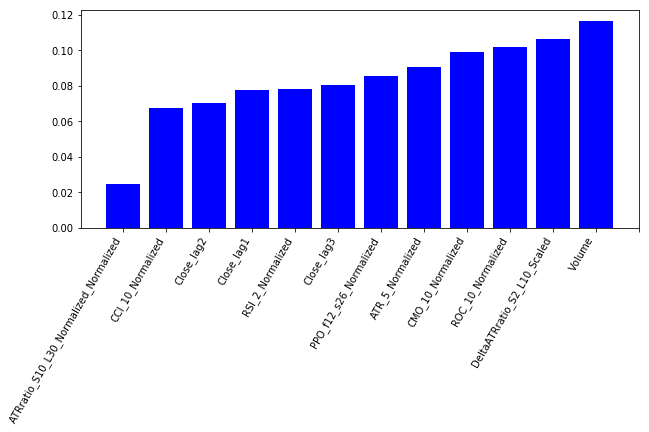

======== KNN =========
======== GTB =========


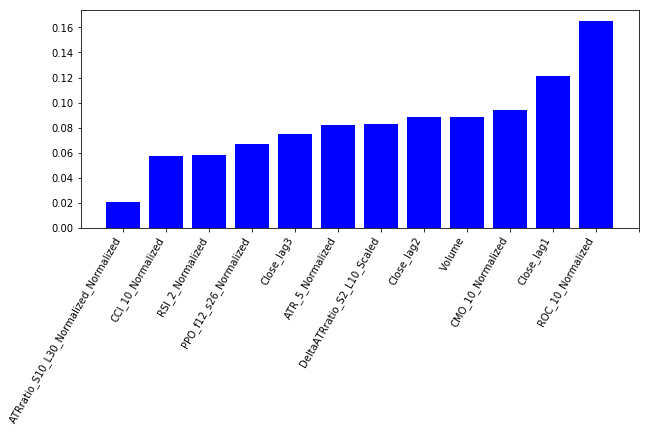

In [ ]:
to_model = {"RF": setRFClass(min_samples_split=20, n_estimators=200), 
            "KNN": setKNNClass(n_neighbors=5),
            "GTB": setGTBClass(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
            "SVM": setSVMClass(C=1)}

names = mmData.columns.values[0:]

for key, value in to_model.items():
    modelname = key
    model = value
    model.fit(dX, dy)
    fi = get_feature_importance(model, modelname)
    print("======== " + modelname + " =========")
    if fi is not None:
        #zipped = zip(names, fi)
        #print(sorted(zipped, key=lambda x: x[1], reverse=True))
#         fi,names = zip(*sorted(zip(fi,names)))
#         plt.bar(range(len(names)), fi, align='center')
#         plt.xticks(range(len(names)), names)
#         plt.show()
        plot_coefficients(fi, names, len(names))